--- 유저별 연도 선호도 요약 ---
   user    mean_year  median_year   std_year  min_year  max_year  count  \
0    11  1997.696809       2000.0   9.864608      1941      2009    376   
1    14  1986.061111       1993.0  20.207351      1925      2008    180   
2    18  1995.012987       2001.0  14.529909      1952      2009     77   
3    25  1991.769231       1994.0   9.416389      1939      2008     91   
4    31  2005.019481       2006.0   5.993974      1974      2014    154   

  preference_type  
0       2000s Fan  
1         90s Fan  
2       2000s Fan  
3         90s Fan  
4       2000s Fan  


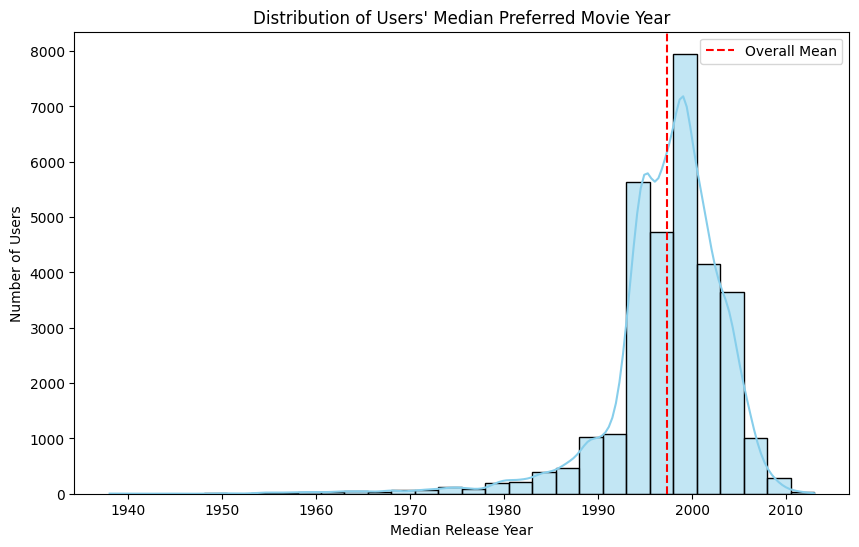

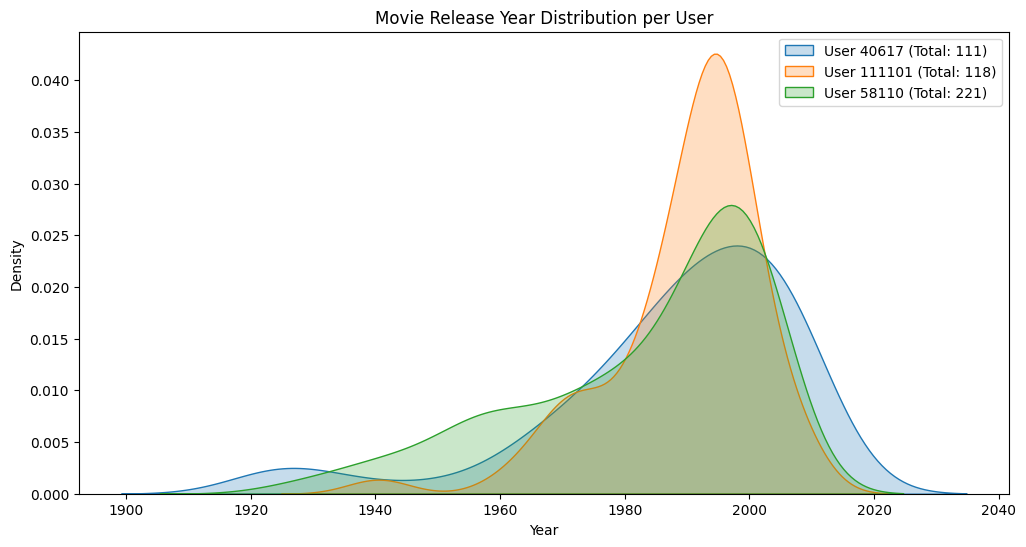

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 데이터 로드 (파일 경로를 환경에 맞게 수정하세요)
train_df = pd.read_csv('/data/ephemeral/home/Seung/data/train/train_ratings.csv')
year_df = pd.read_csv('/data/ephemeral/home/Seung/data/train/years.tsv', sep='\t')

# 2. 데이터 병합 (Item ID 기준)
df = pd.merge(train_df, year_df, on='item', how='left')

# 결측치 처리 (연도 정보가 없는 영화가 있을 수 있음)
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

# 3. 유저별 연도 통계 계산
user_year_stats = df.groupby('user')['year'].agg([
    ('mean_year', 'mean'), 
    ('median_year', 'median'), 
    ('std_year', 'std'),
    ('min_year', 'min'),
    ('max_year', 'max'),
    ('count', 'count')
]).reset_index()

# 4. 유저 성향 분류 (예시: 중앙값 기준)
# 2000년 이전 영화를 주로 보면 'Classic Lover', 이후면 'Modern Lover'
def categorize_user(median_year):
    if median_year < 1990: return 'Old Classic'
    elif median_year < 2000: return '90s Fan'
    elif median_year < 2010: return '2000s Fan'
    else: return 'Modern'

user_year_stats['preference_type'] = user_year_stats['median_year'].apply(categorize_user)

print("--- 유저별 연도 선호도 요약 ---")
print(user_year_stats.head())

# 5. 시각화: 유저들의 선호 연도 중앙값 분포
plt.figure(figsize=(10, 6))
sns.histplot(user_year_stats['median_year'], bins=30, kde=True, color='skyblue')
plt.axvline(user_year_stats['median_year'].mean(), color='red', linestyle='--', label='Overall Mean')
plt.title('Distribution of Users\' Median Preferred Movie Year')
plt.xlabel('Median Release Year')
plt.ylabel('Number of Users')
plt.legend()
plt.show()

# 6. 특정 유저(예: 헤비 유저 vs 라이트 유저)의 연도별 시청 기록 비교 함수
def plot_user_year_dist(user_ids):
    plt.figure(figsize=(12, 6))
    for uid in user_ids:
        user_data = df[df['user'] == uid]
        sns.kdeplot(user_data['year'], label=f'User {uid} (Total: {len(user_data)})', fill=True)
    
    plt.title('Movie Release Year Distribution per User')
    plt.xlabel('Year')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# 예시: 랜덤하게 유저 3명 뽑아서 비교
random_users = user_year_stats.sample(3)['user'].tolist()
plot_user_year_dist(random_users)

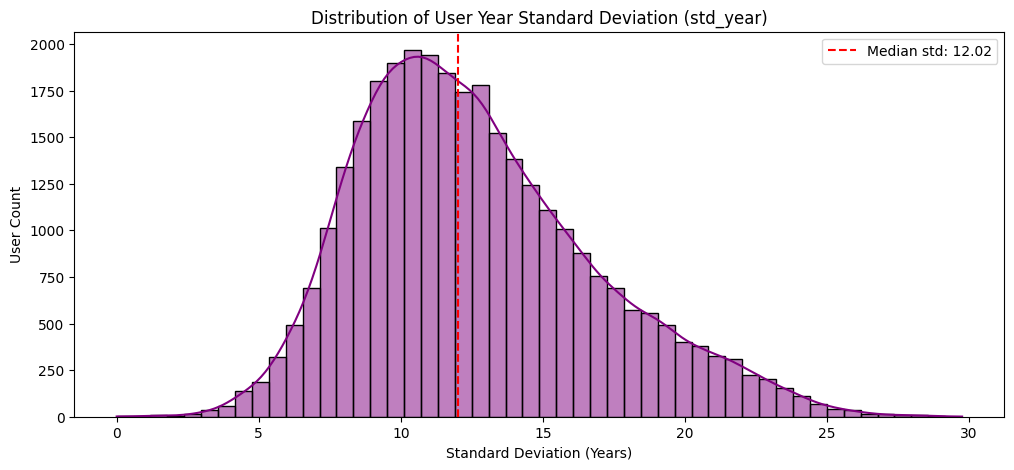

--- 유저 그룹별 분포 ---
consistency_group
Diverse (Time Traveler)           50.220026
Moderate (Decade Focused)         48.778699
Ultra-Focused (Era Specialist)     1.001276
Name: proportion, dtype: float64

총 314명의 '시대 매니아' 발견! 이들의 추천 리스트를 검수해야 해.

[유저 14330 시청 기록 예시]
최초 시청 영화 연도: 1980.0
최근 시청 영화 연도: 2001.0
주요 시청 연도(중앙값): 1986.0
취향 그룹                | 인원수      | 비중(%)   
----------------------------------------
Ultra-Focused (시대 매니아) |    314명 |    1.00%
Moderate (평범한 취향)      |  15297명 |   48.78%
Diverse (잡식성/타임 트래블러)  |  15749명 |   50.22%

[참고] 기록이 2개 이상인 유저들만 대상으로 했을 때:
Ultra-Focused 비중: 1.00%


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 데이터 로드 (네가 사용하던 경로 그대로 유지했어)
train_path = '/data/ephemeral/home/Seung/data/train/train_ratings.csv'
year_path = '/data/ephemeral/home/Seung/data/train/years.tsv'

df_train = pd.read_csv(train_path)
df_year = pd.read_csv(year_path, sep='\t')

# 2. 병합 및 정제
df = pd.merge(df_train, df_year, on='item', how='left')
df = df.dropna(subset=['year']) # 연도 없는 8개 데이터는 일단 제외

# 3. 유저별 연도 표준편차(std_year) 및 기본 통계량 계산
user_stats = df.groupby('user')['year'].agg(['std', 'mean', 'median', 'min', 'max', 'count']).reset_index()
user_stats['std'] = user_stats['std'].fillna(0) # 기록이 1개인 유저는 편차 0

# 4. 분석: std_year 분포 시각화
plt.figure(figsize=(12, 5))
sns.histplot(user_stats['std'], bins=50, kde=True, color='purple')
plt.title('Distribution of User Year Standard Deviation (std_year)')
plt.xlabel('Standard Deviation (Years)')
plt.ylabel('User Count')
plt.axvline(user_stats['std'].median(), color='red', linestyle='--', label=f'Median std: {user_stats["std"].median():.2f}')
plt.legend()
plt.show()

# 5. 유저 그룹화 (취향의 폭에 따라)
def categorize_std(s):
    if s <= 5: return 'Ultra-Focused (Era Specialist)'
    elif s <= 12: return 'Moderate (Decade Focused)'
    else: return 'Diverse (Time Traveler)'

user_stats['consistency_group'] = user_stats['std'].apply(categorize_std)

print("--- 유저 그룹별 분포 ---")
print(user_stats['consistency_group'].value_counts(normalize=True) * 100)

# 6. 실험: 1등을 위한 'Era Specialist' 추출
# 이 유저들은 특정 시대 영화만 보기 때문에, 모델이 추천한 영화가 
# 본인들의 [min - 5, max + 5] 범위를 벗어나면 오답일 확률이 매우 높음.
specialists = user_stats[user_stats['consistency_group'] == 'Ultra-Focused (Era Specialist)']
print(f"\n총 {len(specialists)}명의 '시대 매니아' 발견! 이들의 추천 리스트를 검수해야 해.")

# 예시: 특정 Specialist 유저의 시청 기록 확인
sample_user = specialists.sample(1)['user'].iloc[0]
sample_data = df[df['user'] == sample_user]
print(f"\n[유저 {sample_user} 시청 기록 예시]")
print(f"최초 시청 영화 연도: {sample_data['year'].min()}")
print(f"최근 시청 영화 연도: {sample_data['year'].max()}")
print(f"주요 시청 연도(중앙값): {sample_data['year'].median()}")

# 1. 아까 계산한 user_stats를 바탕으로 카테고리 분류
def categorize_std(s):
    if s <= 5: return 'Ultra-Focused (시대 매니아)'
    elif s <= 12: return 'Moderate (평범한 취향)'
    else: return 'Diverse (잡식성/타임 트래블러)'

user_stats['consistency_group'] = user_stats['std'].apply(categorize_std)

# 2. 인원수와 비중 계산
counts = user_stats['consistency_group'].value_counts()
percentages = user_stats['consistency_group'].value_counts(normalize=True) * 100

# 3. 결과 출력
print("="*40)
print(f"{'취향 그룹':<20} | {'인원수':<8} | {'비중(%)':<8}")
print("-"*40)
for label in ['Ultra-Focused (시대 매니아)', 'Moderate (평범한 취향)', 'Diverse (잡식성/타임 트래블러)']:
    if label in counts:
        print(f"{label:<22} | {counts[label]:>6}명 | {percentages[label]:>7.2f}%")
print("="*40)

# 4. 꿀팁: std가 0인 유저(영화 1개만 본 유저 등) 제외하고 다시 보고 싶다면?
print("\n[참고] 기록이 2개 이상인 유저들만 대상으로 했을 때:")
multi_interaction_users = user_stats[user_stats['count'] > 1]
multi_percentages = multi_interaction_users['consistency_group'].value_counts(normalize=True) * 100
print(f"Ultra-Focused 비중: {multi_percentages.get('Ultra-Focused (시대 매니아)', 0):.2f}%")